# Import Data

In [1]:
!pip install imblearn
!pip install xgboost
from imblearn.over_sampling import SMOTE

In [48]:
#Import packages
import pandas as pd
import numpy as np

import re

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import r2_score
from sklearn.metrics import f1_score

from sklearn.metrics import classification_report

from xgboost import XGBClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [56]:
imdb1 = pd.read_csv('IMDbScrapeFull.csv')
imdb2 = pd.read_csv('IMDbScrape2.csv')

In [57]:
imdbfull = pd.concat([imdb1,imdb2], axis=0)
movie = imdbfull.drop_duplicates()

In [58]:
movie = movie[~movie.duplicated()]
movie = movie.reset_index(drop = True)

for i in range(movie.shape[0]):
    movie['Title'].loc[i] = re.sub(r'[^\w\s]','', movie['Title'].loc[i]) # strip inconsistent punctuation to make merging easier

movie.info() # this is final, pre-merge movie dataframe

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9777 entries, 0 to 9776
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Title           9777 non-null   object 
 1   Release_Date    9777 non-null   object 
 2   ViewRating      4020 non-null   object 
 3   Genres          9543 non-null   object 
 4   Budget          4265 non-null   object 
 5   DomesticGross   4265 non-null   object 
 6   WorldwideGross  4265 non-null   object 
 7   Description     8491 non-null   object 
 8   Keywords        9776 non-null   object 
 9   Runtime         9440 non-null   float64
dtypes: float64(1), object(9)
memory usage: 764.0+ KB


# Begin Cleaning
    - Drop domestic gross profit and use worldwide gross profit
    - Clean worldwide gross profit
    - Clean budget

In [52]:
if 'DomesticGross' in movie.columns:
    
    flag = True # used in next block to ensure rerunning block doesn't throw error
    
    movie = movie.iloc[89:,:] # drop movies made in 2021 since incomplete data
    movie = movie.drop(labels = ['DomesticGross'], axis = 1) # drop domestic, worldwide is more important
    movie['WorldwideGross'] = movie['WorldwideGross'].str.replace(',','')
    movie['Budget'] = movie['Budget'].str.replace(',','')
    movie['Budget'] = movie['Budget'].str.split(' ').str[0]
    movie = movie.dropna(subset = ['WorldwideGross'], axis = 0)
    movie = movie.reset_index(drop = True)

    for i in range(movie['WorldwideGross'].shape[0]): 
        if (movie['WorldwideGross'].loc[i] == 'Non') | (movie['WorldwideGross'].loc[i][0] == '<'):
            movie = movie.drop(index = i)
        else:
            continue
            
    movie = movie.reset_index(drop = True)

            
    for i in range(movie['Budget'].shape[0]): 
        if (movie['Budget'].loc[i] == 'Non') | (movie['Budget'].loc[i][0] == '<'):
            movie = movie.drop(index = i)
        else:
            continue
            
    movie = movie.reset_index(drop = True)
    
    

movie['WorldwideGross'] = movie['WorldwideGross'].astype(int)
movie['Budget'] = movie['Budget'].astype(int)
movie.info()

,Title,Release_Date,ViewRating,Genres,Budget,WorldwideGross,Description,Keywords,Runtime
0,The Invisible Man,2020,R,Drama Horror Mystery Sci-Fi Thriller,7000000,143151000,"The film follows Cecilia, who receives the new...",domestic abuse psychological abuse invisibilit...,124.0
1,Emma.,2020,PG,Comedy Drama Romance,10000000,26404660,Jane Austen's beloved comedy about finding you...,nineteenth century female protagonist declarat...,124.0
2,Dolittle,2020,PG,Adventure Comedy Family Fantasy,175000000,245438444,"After his wife's death, Dr. John Dolittle (Rob...",gorilla grief duck live action cgi hybrid ship...,74.0
3,The Call of the Wild,2020,PG,Adventure Drama Family,135000000,111105497,The Call of the Wild is a vibrant story of Buc...,1890s remake alaska snow dog 93 more,64.0
4,The Rhythm Section,2020,R,Action Drama Mystery Thriller,50000000,5989583,"Blake Lively stars as Stephanie Patrick, an or...",female assassin revenge terrorism female prota...,154.0
...,...,...,...,...,...,...,...,...,...
1369,Love Story,1970,PG,Drama Romance,2200000,106550690,The love story of young adults Oliver Barrett ...,love famous line baker main character dies 197...,60.0
1370,Airport,1970,G,Action Drama Thriller,10000000,100489151,"This precursor to later ""epic"" 1970s disaster ...",boeing 707 cockpit air crew airport bomb 220 m...,120.0
1371,Little Big Man,1970,PG-13,Adventure Comedy Drama Western,15000000,31559552,Jack Crabb is 121 years old as the film begins...,revisionist western based on novel cheyenne in...,120.0
1372,Beneath the Planet of the Apes,1970,G,Action Adventure Sci-Fi,3000000,18999718,"Brent is an American astronaut, part of a team...",ape planet of the apes planet astronaut rescue...,60.0


# Organizing, reshuffling, renaming etc. 

count    1374.000000
mean        2.482462
std         4.330006
min         0.000034
25%         0.378290
50%         1.287334
75%         2.822895
max        67.344471
Name: Revenue-Budget-Ratio, dtype: float64

Median: 1.2873343


(-1.0, 35.0)

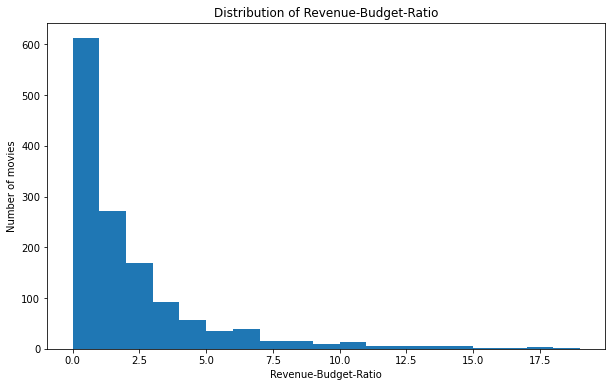

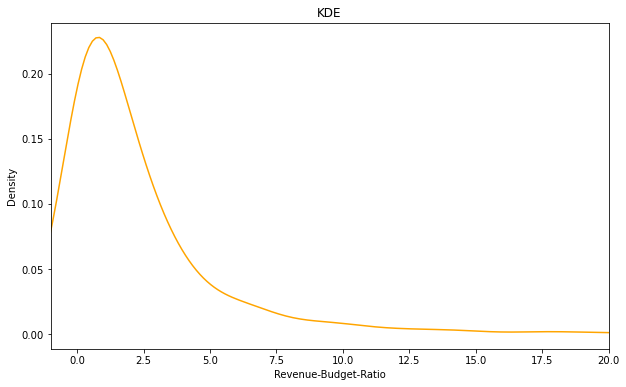

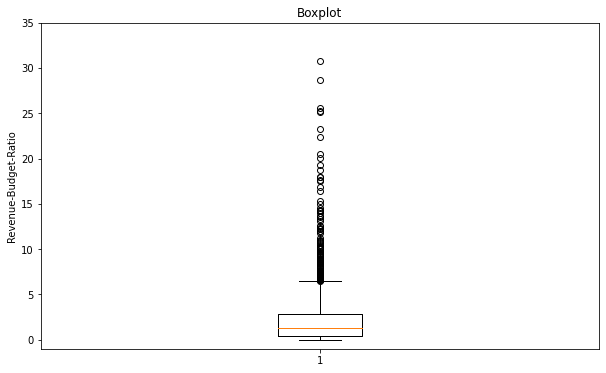

In [53]:
if flag: 
    flag = False
    movie = movie.rename(columns = {'Release_Date': 'Year','ViewRating':'Rating'})
    movie['Revenue-Budget-Ratio'] = movie['WorldwideGross'] / movie['Budget']
    movie['Year'] = movie['Year'].astype(int)
    movie['Runtime'] = movie['Runtime'].astype(int)
    
    movie['Rating'] = movie['Rating'].fillna('Unknown')

# VISUALIZATION: 

print(movie['Revenue-Budget-Ratio'].describe()) # aggregate statistics
print('')
print('Median:',movie['Revenue-Budget-Ratio'].median()) 


target = movie['Revenue-Budget-Ratio']
bins = np.arange(0,20,1)
plt.figure(figsize = (10,6))
plt.hist(target, bins = bins)
plt.title('Distribution of Revenue-Budget-Ratio')
plt.xlabel('Revenue-Budget-Ratio')
plt.ylabel('Number of movies')

plt.figure(figsize = (10,6))
target.plot(kind = 'kde', color = 'orange' )
plt.title('KDE')
plt.xlabel('Revenue-Budget-Ratio')
plt.xlim(-1,20)

plt.figure(figsize = (10,6))
plt.boxplot(target)
plt.title('Boxplot')
plt.ylabel('Revenue-Budget-Ratio')
plt.ylim(-1,35)


# Distribution is clearly exponential or poisson - I THINK??
Analysis: 

This makes sense. A larger ratio is a financially successful movie. Many movies are not successful, and in fact for every ~10 movies only about 3 are successful, paying for the 7 unsuccessful ones. Subsequently, it makes perfect sense that the distribution of this revenue/budget ratio is skewed heavily towards the lower end. 

A ratio of 1 means that the company actually lost money on the movie, since revenue does not take into account costs, so the profit would be less than the budget (i.e. a loss). 

The median of the data is 1.29 and the mean is 2.48. Therefore, while we don't have a lot of data, it does seem to be representative of the overall larger distribution of movies. The median revenue/budget ratio is a financial loss, and the mean is a bit better since it includes the outliers (the successful movies). 

While there are a lot of outliers here (as seen on the boxplot), these are very imporatnt to include since ultimately when a movie studio makes a movie, they want to be the outlier themselves. (outlier = highly profitable)

In [54]:
movie = movie.drop(labels = ['Budget','WorldwideGross'], axis = 1) # dropping these since our target is a function of these two features

# Ordinal Encoding Ratings

In [37]:
for i in range(movie.shape[0]):
    if (movie['Rating'].loc[i]) == '':
        continue
    elif (movie['Rating'].loc[i]) == 'TV-PG':
        movie['Rating'].loc[i] = 'PG'
    elif (movie['Rating'].loc[i]) == 'Unrated':
        movie['Rating'].loc[i] = 'Not Rated'
    elif (movie['Rating'].loc[i]) == 'TV-14':
        movie['Rating'].loc[i] = 'PG-13'
    elif (movie['Rating'].loc[i]) == 'TV-MA':
        movie['Rating'].loc[i] = 'NC-17'
    elif (movie['Rating'].loc[i]) == 'X':
        movie['Rating'].loc[i] = 'NC-17'
    elif (movie['Rating'].loc[i]) == 'GP':
        movie['Rating'].loc[i] = 'PG'
    elif (movie['Rating'].loc[i]) == 'Approved':
        movie['Rating'].loc[i] = 'R'
        
# ordinal encoding myself

ratings = {'G':0.0, 'PG':1.0, 'PG-13':2.0,'R':3.0,'NC-17':4.0, 'Not Rated':5.0, 'Unknown':6.0} # dictionary mapping
movie['Rating'] = movie['Rating'].replace(ratings) # replace categories with ordinally encoded values

# One-Hot Encoding Genre

In [38]:
movie['Genres'] = movie['Genres'].str.split(' ').str[0] # grab first genre in list and assign this as the movie's single genre
movie = movie.rename(columns = {'Genres':'Genre'}) # rename to singular form
flag = True

In [39]:
if flag:
    flag = False
    enc = OneHotEncoder(handle_unknown='ignore') # one-hot encoder
    enc.fit(np.array(movie['Genre']).reshape(-1,1))

    columns = list(enc.get_feature_names())

    for i in range(len(columns)):
        columns[i] = columns[i].split('_')[-1]

    enc_vals = enc.transform(np.array(movie['Genre']).reshape(-1,1))
    enc_df = pd.DataFrame(enc_vals.toarray(), columns = columns)

    targets = movie['Revenue-Budget-Ratio']
    movie = pd.concat([movie.drop(labels = ['Revenue-Budget-Ratio','Genre'], axis = 1),enc_df,targets], axis = 1)


# Remove additional duplicates that Maria found

# Merge with cleaned book data from Miranda

In [41]:
book = pd.read_csv('mm_LibraryThingFull.csv')
book = book.drop(labels = ['Link1','Link2'],axis = 1)
book['SearchTerm'] = book['SearchTerm'].str.split(' \[').str[0]

book['Year'] = book['Year'].str.split('[').str[-1].str.split(' film').str[0]
book['author_x'] = book['author_x'].str.split('by ').str[-1]
book = book.rename(columns = {'SearchTerm':'movie_title','Year':'movie_year' ,'AdaptationOf':'book_title','published_x':'book_year','author_x':'author','series_x':'num_books_in_series','rating_x':'book_rating','charnum_x':'charnum','awardnum_x':'awardnum'})

books_and_movies = pd.merge(movie,book, how = 'inner', left_on = 'Title', right_on = 'movie_title')
books_and_movies = books_and_movies.drop_duplicates(subset = ['Title','Year']) # drop any duplicate entries in the dataframe
books_and_movies = books_and_movies.reset_index(drop = True)

test = pd.merge(movie,book, how = 'inner', left_on = 'Title', right_on = 'book_title')
test = test.drop_duplicates(subset = ['Title','Year']) # drop any duplicate entries in the dataframe
test = test.reset_index(drop = True)

books_and_movies

,Title,Year,Rating,Description,Keywords,Runtime,Action,Adventure,Animation,Biography,...,Revenue-Budget-Ratio,movie_title,movie_year,book_title,book_year,author,num_books_in_series,book_rating,charnum,awardnum
0,The Invisible Man,2020,3.0,"The film follows Cecilia, who receives the new...",domestic abuse psychological abuse invisibilit...,124,0.0,0.0,0.0,0.0,...,20.450143,The Invisible Man,2020,The Invisible Man,1897.0,H. G. Wells,0.0,-3.53,18.0,6.0
1,Emma,2020,1.0,Jane Austen's beloved comedy about finding you...,nineteenth century female protagonist declarat...,124,0.0,0.0,0.0,0.0,...,2.640466,Emma,2020,Emma,1816.0,Jane Austen,0.0,-4.07,69.0,19.0
2,Emma,1996,1.0,Emma Woodhouse is a congenial young lady who d...,matchmaker blonde title same as book female na...,122,0.0,0.0,0.0,0.0,...,3.705276,Emma,2020,Emma,1816.0,Jane Austen,0.0,-4.07,69.0,19.0
3,The Call of the Wild,2020,1.0,The Call of the Wild is a vibrant story of Buc...,1890s remake alaska snow dog 93 more,64,0.0,1.0,0.0,0.0,...,0.823004,The Call of the Wild,2020,The Call of the Wild,1903.0,Jack London,0.0,-3.79,24.0,25.0
4,The Rhythm Section,2020,3.0,"Blake Lively stars as Stephanie Patrick, an or...",female assassin revenge terrorism female prota...,154,1.0,0.0,0.0,0.0,...,0.119792,The Rhythm Section,The Rhythm Section,NaN,1999.0,Mark Burnell,1.0,-3.70,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
893,Johnny Got His Gun,1971,3.0,"Joe, a young American soldier, is hit by a mor...",nonlinear timeline black and white and color v...,60,0.0,0.0,0.0,0.0,...,0.002735,Johnny Got His Gun,1971,Johnny Got His Gun,1939.0,Dalton Trumbo,0.0,-4.17,8.0,3.0
894,Love Story,1970,1.0,The love story of young adults Oliver Barrett ...,love famous line baker main character dies 197...,60,0.0,0.0,0.0,0.0,...,48.432132,Love Story,1970,Love Story,1970.0,Erich Segal,1.0,-3.36,5.0,7.0
895,Airport,1970,0.0,"This precursor to later ""epic"" 1970s disaster ...",boeing 707 cockpit air crew airport bomb 220 m...,120,1.0,0.0,0.0,0.0,...,10.048915,Airport,1970,Airport,NaN,Arthur Hailey,0.0,-3.55,11.0,3.0
896,Little Big Man,1970,2.0,Jack Crabb is 121 years old as the film begins...,revisionist western based on novel cheyenne in...,120,0.0,1.0,0.0,0.0,...,2.103970,Little Big Man,1970,Little Big Man,1964.0,"Thomas Berger, Thomas Berger",1.0,-4.15,1.0,5.0


# Analysis of books_and_movies
- Data distribution still representative of overall distribution of movies, as you can tell by the shape of the histogram

In [47]:
books_and_movies = books_and_movies.drop(labels = ['movie_title','book_title','movie_year'], axis = 1)


target = books_and_movies['Revenue-Budget-Ratio']
print(target.describe())
print('')
print('Median:',target.median())

bins = np.arange(0,25,1)
plt.figure(figsize = (10,6))
plt.hist(target, bins = bins)


books_and_movies['book_rating'] = books_and_movies['book_rating'].fillna(books_and_movies['book_rating'].median())
books_and_movies['book_rating'] = (books_and_movies['book_rating'].astype(float) * -1)


KeyError: "['movie_title' 'book_title' 'movie_year'] not found in axis"

# Import NYT Bestsellers

In [30]:
'''nytimes = pd.read_csv('NYCBestsellers.csv')
best_authors = nytimes['author'].drop_duplicates().reset_index(drop = True)
our_authors = books_and_movies['author'].drop_duplicates().reset_index(drop = True)

# best_authors
# our_authors
test = pd.merge(best_authors,our_authors, how = 'inner')

books_and_movies['NYTBestsellingAuthor'] = 0

for i in range(books_and_movies.shape[0]):
    if (books_and_movies['author'].loc[i] in list(test['author'])):
        books_and_movies['NYTBestsellingAuthor'].loc[i] = 1'''

KeyError: 'author'

# Select things made in or after 2008

In [16]:
#books_and_movies = books_and_movies[books_and_movies['Year']>=2008]
#books_and_movies.info()


In [45]:
books_and_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 898 entries, 0 to 897
Data columns (total 28 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Revenue-Budget-Ratio  898 non-null    float64
 1   Title                 898 non-null    object 
 2   Year                  898 non-null    int32  
 3   Rating                898 non-null    float64
 4   Description           895 non-null    object 
 5   Keywords              898 non-null    object 
 6   Runtime               898 non-null    int32  
 7   Action                898 non-null    float64
 8   Adventure             898 non-null    float64
 9   Animation             898 non-null    float64
 10  Biography             898 non-null    float64
 11  Comedy                898 non-null    float64
 12  Crime                 898 non-null    float64
 13  Drama                 898 non-null    float64
 14  Family                898 non-null    float64
 15  Fantasy               8

# Feature correlation analysis with target: 

In [43]:
targ = books_and_movies['Revenue-Budget-Ratio']
books_and_movies = pd.concat([targ,books_and_movies.drop(labels = ['Revenue-Budget-Ratio'], axis = 1)],axis = 1)
correlation = books_and_movies.corr()
correlation.iloc[1:,:1]

,Revenue-Budget-Ratio
Year,-0.120804
Rating,-0.119113
Runtime,0.026282
Action,-0.007471
Adventure,0.039014
Animation,0.010060
Biography,-0.017389
Comedy,-0.039341
Crime,-0.028637
Drama,0.002097


# Prepare for modeling

In [19]:
targets = books_and_movies['Revenue-Budget-Ratio']
books_and_movies = books_and_movies.drop(labels = ['Title','Description','Keywords','author','Revenue-Budget-Ratio'], axis = 1)

In [20]:
books_and_movies['num_books_in_series'] = books_and_movies['num_books_in_series'].fillna(1)
books_and_movies['charnum'] = books_and_movies['charnum'].fillna(books_and_movies['charnum'].median())
books_and_movies['awardnum'] = books_and_movies['awardnum'].fillna(0)
books_and_movies['book_year'] = books_and_movies['book_year'].fillna(books_and_movies['book_year'].median()) # this is a questionable decision?


# Convert continuous output to categorical output

0.0    780
1.0    118
Name: Revenue-Budget-Ratio, dtype: int64


Text(0.5, 1.0, 'Class Imbalance Visualization')

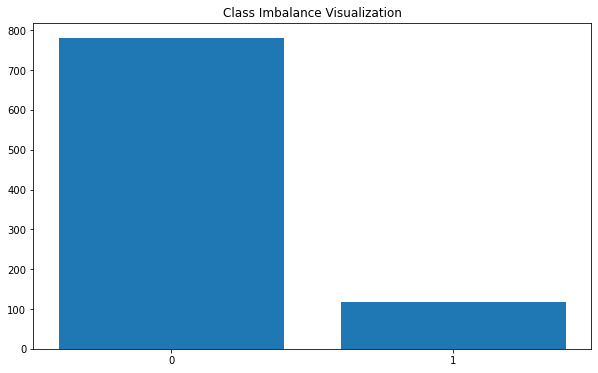

In [21]:
X = books_and_movies
y = targets

scaler = StandardScaler()
X = scaler.fit_transform(X)


for i in range(len(y)):
    if (y.iloc[i] < 5):
        y.iloc[i] = 0
    else:
        y.iloc[i] = 1
        
print(y.value_counts())

X_train_full, X_test, y_train_full, y_test = train_test_split(X,y,stratify=y, test_size = 0.20)

plt.figure(figsize = (10,6))
plt.bar([0,1],height = [y.value_counts()[0.0],y.value_counts()[1.0]])
plt.xticks([0,1])
plt.title('Class Imbalance Visualization')

# Model creation / validation

In [22]:
def get_average_auroc(X,y,estimator,num_iter):
    
    auroc = []
    
    for n in range(num_iter):
        X_train, X_val, y_train, y_val = train_test_split(X,y,stratify = y,test_size = 0.20)
        
        sm = SMOTE(random_state = 42) # SMOTE
        X_train, y_train = sm.fit_resample(X_train, y_train)
        
        estimator.fit(X_train,y_train)
        preds = estimator.predict(X_val)
        auroc.append(roc_auc_score(y_val,preds))
    
    return np.round(np.mean(auroc),3)

In [23]:
lg = get_average_auroc(X_train_full,y_train_full,LogisticRegression(),100)
print('Average logistic regression AUROC:',lg)

mlp = get_average_auroc(X_train_full,y_train_full,MLPClassifier(),25)
print('Average mlp AUROC:',mlp)

rf = get_average_auroc(X_train_full,y_train_full,RandomForestClassifier(max_depth=4, n_estimators=100),25)
print('Average rf AUROC:',rf)

knn = get_average_auroc(X_train_full,y_train_full,KNeighborsClassifier(),100)
print('Average knn AUROC:',knn)

Average logistic regression AUROC: 0.607
Average mlp AUROC: 0.574
Average rf AUROC: 0.614
Average knn AUROC: 0.59


# We are choosing logistic regression as it is best performing model

# Evaluate final model performance on the test set

In [24]:
auroc = []

final_model = LogisticRegression()
final_model.fit(X_train_full,y_train_full)
preds = final_model.predict(X_test)
auroc.append(roc_auc_score(y_test,preds))
    
print('AUROC on single trial:',np.round(np.mean(auroc),3))

print(classification_report(y_test,preds))

auroc = []
precision = []

for _ in range(150):
    X_train_full, X_test, y_train_full, y_test = train_test_split(X,y,stratify=y, test_size = 0.20)
    final_model = LogisticRegression()
    final_model.fit(X_train_full,y_train_full)
    preds = final_model.predict(X_test)
    auroc.append(roc_auc_score(y_test,preds))
    precision.append(classification_report(y_test,preds, output_dict = True)['1.0']['precision'])

print('Average AUROC over 100 trials:',np.round(np.mean(auroc),3))
print('Average precision for 1.0 class over 100 trials:',np.round(np.mean(precision),3))



AUROC on single trial: 0.497
              precision    recall  f1-score   support

         0.0       0.87      0.99      0.93       156
         1.0       0.00      0.00      0.00        24

    accuracy                           0.86       180
   macro avg       0.43      0.50      0.46       180
weighted avg       0.75      0.86      0.80       180

Average AUROC over 100 trials: 0.51
Average precision for 1.0 class over 100 trials: 0.302


# Logistic Regression averaging 0.577 AUROC over 100 trials